In [127]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [128]:
import yfinance as yf

data = yf.download(tickers = "6C=F", start="2017-12-01", end="2023-06-16", interval='1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,0.77545,0.78870,0.77540,0.78780,0.78780,159130
2017-12-04,0.78715,0.79025,0.78585,0.78765,0.78765,74216
2017-12-05,0.78860,0.79225,0.78725,0.78760,0.78760,62736
2017-12-06,0.78800,0.79040,0.78090,0.78135,0.78135,87079
2017-12-07,0.78175,0.78220,0.77720,0.77755,0.77755,73507
...,...,...,...,...,...,...
2023-06-09,0.74870,0.75125,0.74800,0.74910,0.74910,88366
2023-06-12,0.74975,0.75115,0.74730,0.74795,0.74795,103912
2023-06-13,0.74820,0.75275,0.74760,0.75140,0.75140,98718


In [129]:
data = data.reset_index('Date', inplace=False)

In [130]:
# Chuyển cột 'Date' thành kiểu dữ liệu datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sắp xếp dữ liệu theo thứ tự tăng dần của cột 'Date'
data.sort_values(by='Date', inplace=True)

# Chuyển cột 'Date' thành mảng numpy
dates = data['Date'].values

# Chuyển cột 'Close' thành mảng numpy
close_prices = data['Close'].values

In [131]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [132]:
train_dates = train_data['Date'].values
train_close_prices = train_data['Close'].values
val_dates = val_data['Date'].values
val_close_prices = val_data['Close'].values
test_dates = test_data['Date'].values
test_close_prices = test_data['Close'].values

In [133]:
train_dates = train_data.index.values
test_dates = test_data.index.values
val_dates = val_data.index.values

In [134]:
X_train = torch.from_numpy(train_dates.reshape(-1, 1)).float()
y_train = torch.from_numpy(train_close_prices.reshape(-1, 1)).float()
X_test = torch.from_numpy(test_dates.reshape(-1, 1)).float()
y_test = torch.from_numpy(test_close_prices.reshape(-1, 1)).float()
X_val = torch.from_numpy(val_dates.reshape(-1, 1)).float()
y_val = torch.from_numpy(val_close_prices.reshape(-1, 1)).float()

In [135]:
# Xác định kiến trúc của mạng Bayesian Neural Network
class BNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [136]:
# Xác định hàm mất mát và bộ tối ưu hóa
criterion = nn.MSELoss()
learning_rate = 0.001
num_epochs = 1000

In [137]:
# Khởi tạo mô hình BNN
model = BNN(input_size=1, output_size=1)

In [138]:
# Huấn luyện mô hình BNN
for epoch in range(num_epochs):
    model.train()

    # Tính đầu ra dự đoán của mô hình
    y_pred = model(X_train)

    # Tính lỗi dự đoán so với giá thực tế
    loss = criterion(y_pred, y_train)

    # Backpropagation và cập nhật trọng số
    loss.backward()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


Epoch [100/1000], Loss: 9.535645484924316
Epoch [200/1000], Loss: 0.3195483684539795
Epoch [300/1000], Loss: 17.08234214782715
Epoch [400/1000], Loss: 24.806116104125977
Epoch [500/1000], Loss: 0.24018637835979462
Epoch [600/1000], Loss: 0.1528429239988327
Epoch [700/1000], Loss: 0.08312029391527176
Epoch [800/1000], Loss: 8.630929946899414
Epoch [900/1000], Loss: 0.07355649024248123
Epoch [1000/1000], Loss: 0.0028748661279678345


In [139]:
# Dự đoán trên tập test
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)

In [140]:
# Dự đoán trên tập validation
model.eval()
with torch.no_grad():
    y_pred_val = model(X_val)

In [141]:
# In kết quả dự đoán trên tập test
print('Kết quả dự đoán trên tập test:')
for i in range(len(test_dates)):
    print(f'Date: {test_dates[i]}, Predicted Close: {y_pred_test[i].item()}')

Kết quả dự đoán trên tập test:
Date: 969, Predicted Close: 0.8891576528549194
Date: 970, Predicted Close: 0.8892786502838135
Date: 971, Predicted Close: 0.889399528503418
Date: 972, Predicted Close: 0.8895204067230225
Date: 973, Predicted Close: 0.8896414041519165
Date: 974, Predicted Close: 0.889762282371521
Date: 975, Predicted Close: 0.889883279800415
Date: 976, Predicted Close: 0.8900041580200195
Date: 977, Predicted Close: 0.8901250958442688
Date: 978, Predicted Close: 0.8902459740638733
Date: 979, Predicted Close: 0.8903669118881226
Date: 980, Predicted Close: 0.8904878497123718
Date: 981, Predicted Close: 0.8906087875366211
Date: 982, Predicted Close: 0.8907296657562256
Date: 983, Predicted Close: 0.8908505439758301
Date: 984, Predicted Close: 0.8909715414047241
Date: 985, Predicted Close: 0.8910925388336182
Date: 986, Predicted Close: 0.8912134170532227
Date: 987, Predicted Close: 0.8913342952728271
Date: 988, Predicted Close: 0.8914552330970764
Date: 989, Predicted Close: 0.89

In [142]:
# In kết quả dự đoán trên tập validation
print('Kết quả dự đoán trên tập validation:')
for i in range(len(val_dates)):
    print(f'Date: {val_dates[i]}, Predicted Close: {y_pred_val[i].item()}')


Kết quả dự đoán trên tập validation:
Date: 1246, Predicted Close: 0.9226539731025696
Date: 1247, Predicted Close: 0.9227749109268188
Date: 1248, Predicted Close: 0.9228957891464233
Date: 1249, Predicted Close: 0.9230167269706726
Date: 1250, Predicted Close: 0.9231377243995667
Date: 1251, Predicted Close: 0.9232586026191711
Date: 1252, Predicted Close: 0.9233794808387756
Date: 1253, Predicted Close: 0.9235004782676697
Date: 1254, Predicted Close: 0.923621416091919
Date: 1255, Predicted Close: 0.9237422943115234
Date: 1256, Predicted Close: 0.9238631725311279
Date: 1257, Predicted Close: 0.923984169960022
Date: 1258, Predicted Close: 0.9241051077842712
Date: 1259, Predicted Close: 0.9242259860038757
Date: 1260, Predicted Close: 0.924346923828125
Date: 1261, Predicted Close: 0.9244678616523743
Date: 1262, Predicted Close: 0.9245887994766235
Date: 1263, Predicted Close: 0.9247097373008728
Date: 1264, Predicted Close: 0.9248306155204773
Date: 1265, Predicted Close: 0.9249515533447266
Date: 

In [143]:
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
#x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

x_next_30_days = torch.from_numpy(np.array(range(last_index+1, last_index+31)).reshape(-1, 1)).float()
# Dự đoán giá đóng cửa cho 30 ngày tiếp theo
model.eval()
with torch.no_grad():
    y_pred_next = model(x_next_30_days)

# Chuyển đổi kết quả dự đoán thành mảng numpy
y_pred_next = y_pred_next.numpy().flatten()

# Hiển thị kết quả dự đoán
for i in range(len(x_next_30_days)):
    print(f'Date: {x_next_30_days[i]}, Predicted Close: {y_pred_next[i]}')

Date: tensor([1385.]), Predicted Close: 0.9394626021385193
Date: tensor([1386.]), Predicted Close: 0.9395834803581238
Date: tensor([1387.]), Predicted Close: 0.939704418182373
Date: tensor([1388.]), Predicted Close: 0.9398254156112671
Date: tensor([1389.]), Predicted Close: 0.9399462938308716
Date: tensor([1390.]), Predicted Close: 0.9400672316551208
Date: tensor([1391.]), Predicted Close: 0.9401881694793701
Date: tensor([1392.]), Predicted Close: 0.9403091073036194
Date: tensor([1393.]), Predicted Close: 0.9404299855232239
Date: tensor([1394.]), Predicted Close: 0.9405508637428284
Date: tensor([1395.]), Predicted Close: 0.9406718611717224
Date: tensor([1396.]), Predicted Close: 0.9407927393913269
Date: tensor([1397.]), Predicted Close: 0.940913736820221
Date: tensor([1398.]), Predicted Close: 0.9410346150398254
Date: tensor([1399.]), Predicted Close: 0.9411555528640747
Date: tensor([1400.]), Predicted Close: 0.9412764310836792
Date: tensor([1401.]), Predicted Close: 0.9413973689079285

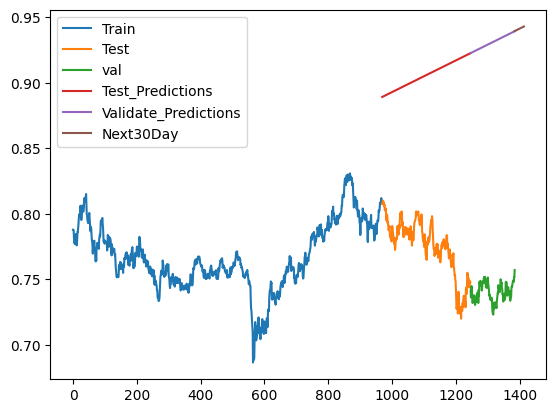

In [144]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data, y_pred_next)
plt.legend(['Train', 'Test','val', 'Test_Predictions','Validate_Predictions','Next30Day'])
plt.show()